In [4]:
import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras.applications.xception as xception
import zipfile
import sys
import time
import re

from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.models import Model, Sequential
import keras.utils as image
from keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [5]:
base_path = 'Chess/'

categories = {
    0 : 'Bishop',
    1 : 'King',
    2 : 'Knight',
    3 : 'Pawn',
    4 : 'Queen',
    5 : 'Rook'
}

In [6]:
def prefix_added(df, column):
    df[column] = df[column].apply(lambda x: x[:re.search("\d", x).start()] + '/' + x)
    df[column] = df['category'].map(categories) + df[column]
    return df

filenames_list = []
category_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    filenames_list = filenames_list + filenames
    category_list = category_list + [category] * len(filenames)

df = pd.DataFrame({
    'filename': filenames_list,
    'category': category_list
})

df = prefix_added(df, 'filename')

df = df.sample(frac=1).reset_index(drop=True)
print('number of elements = ' , len(df))

number of elements =  556


Knight/00000112.jpg


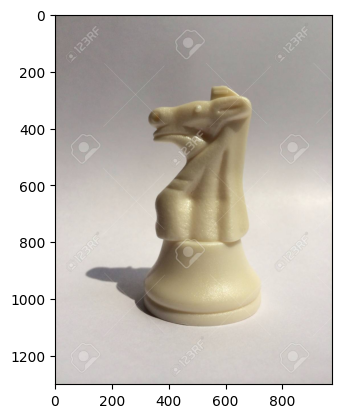

In [7]:
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = image.load_img(base_path +sample['filename'])
print(sample['filename'])
plt.imshow(randomimage)

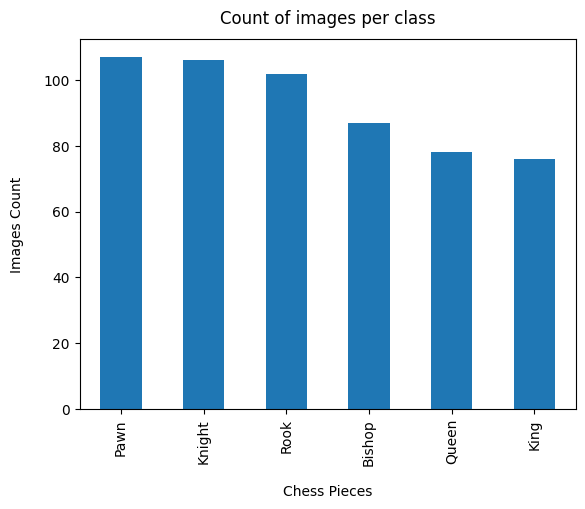

In [8]:
df_visual = df.copy()
df_visual['category'] = df_visual['category'].apply(lambda x: categories[x])
df_visual['category'].value_counts().plot.bar(x = 'count', y = 'category' )
plt.xlabel("Chess Pieces", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

### Personal notes on Xception
The Xception model is a type of computer program that can recognize things in pictures. It's been trained on a really big dataset of over a million pictures called ImageNet. We're going to use this program as a starting point for recognizing things in our own pictures.

We don't need the Xception program to tell us what category each picture belongs to out of the 1,000 categories in ImageNet. We want it to tell us if a picture belongs to a specific category that we care about, like 'cat' or 'dog'. To do that, we need to make some changes to the program.

First, we're going to take out the part of the program that tells us what category a picture belongs to out of the 1,000 categories in ImageNet. We don't need that part anymore.

Second, we're going to add some code to the program that helps it work better with our own pictures. This code will change the pictures so that they look more like the pictures that the Xception program was trained on. This is important because the Xception program is used to seeing pictures in a certain way, and we want our pictures to look similar so that the program works well.

Third, we're going to add some more code to the program that helps it figure out what's in our pictures. This code will take the picture and turn it into a set of numbers that the program can understand. Then, it will look at those numbers and figure out what's in the picture.

Fourth, we're going to add some more code that helps the program understand the results it gets. This code will take the numbers that the program comes up with and figure out what category they belong to. Then, it will give us an answer based on what category our picture belongs to.

So when we put it all together, we have a program that can take our picture, change it so that it looks more like the pictures that the Xception program was trained on, figure out what's in the picture, and then tell us if it belongs to the category that we care about.

In [9]:
folders = 'Chess'
for folder in os.listdir(folders):
    folder_path = f'{folders}/{folder}'
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Open the image file using PIL and get its size
            image_path = os.path.join(folder_path, filename)
            with Image.open(image_path) as img:
                width, height = img.size
                print("Image:", filename, "Size:", width, "x", height)

Image: 00000158.jpg Size: 450 x 468
Image: 00000010.jpg Size: 715 x 1300
Image: 00000004.jpg Size: 726 x 1436
Image: 00000011.jpg Size: 450 x 470
Image: 00000039.jpg Size: 162 x 342
Image: 00000167.jpg Size: 999 x 2025
Image: 00000007.jpg Size: 863 x 1390
Image: 00000013.jpg Size: 391 x 879
Image: 00000012.jpg Size: 2274 x 1819
Image: 00000006.jpg Size: 1000 x 1080
Image: 00000199.jpg Size: 683 x 1024
Image: 00000189.jpg Size: 334 x 500
Image: 00000016.jpg Size: 2453 x 1962
Image: 00000003.png Size: 276 x 290
Image: 00000017.jpg Size: 2131 x 3183
Image: 00000188.jpg Size: 200 x 300
Image: 00000177.jpg Size: 750 x 1000
Image: 00000175.jpg Size: 400 x 400
Image: 00000149.jpg Size: 512 x 512
Image: 00000001.jpg Size: 1000 x 1080
Image: 00000015.png Size: 1920 x 1080
Image: 00000028.jpg Size: 1024 x 1024
Image: 00000174.jpg Size: 212 x 400
Image: 00000113.png Size: 820 x 1637
Image: 00000066.jpg Size: 177 x 300
Image: 00000112.jpg Size: 344 x 500
Image: 00000138.jpg Size: 1300 x 1390
Image

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import keras.applications.xception as xception
import keras

IMAGE_WIDTH = 3183    
IMAGE_HEIGHT = 2453
IMAGE_CHANNELS = 3

xception_layer = xception.Xception(include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS),
                       weights = 'imagenet')

xception_layer.trainable = False
model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

def xception_preprocessing(img):
  return xception.preprocess_input(img)

model.add(Lambda(xception_preprocessing))

model.add(xception_layer)
model.add(keras.layers.GlobalAveragePooling2D())
model.add(Dense(len(categories), activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 3183, 2453, 3)     0         
                                                                 
 xception (Functional)       (None, 100, 77, 2048)     20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 6)                 12294     
                                                                 
Total params: 20,873,774
Trainable params: 12,294
Non-trainable params: 20,861,480
_________________________________________________________________


In [11]:
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_categorical_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)

callbacks = [early_stop]

print('call back defined!')

call back defined!


In [12]:
df["category"] = df["category"].replace(categories) 

trained_df, validated_df = train_test_split(df, test_size=0.2, random_state=42)
validated_df, test_df = train_test_split(validated_df, test_size=0.5, random_state=42)


trained_df = trained_df.reset_index(drop=True)
validated_df = validated_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = trained_df.shape[0]
total_validate = validated_df.shape[0]

print('total size = ', total_validate , 'validate = ', total_validate, 'test = ', test_df.shape[0])

total size =  56 validate =  56 test =  56


## Train the model

In [13]:
from keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
batch = 64

train_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_dataframe(
    trained_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch
)

Found 440 validated image filenames belonging to 6 classes.


/Users/agentsmith/.pyenv/versions/3.10.9/envs/ml-image/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 4 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [14]:
validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validated_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch
)

Found 55 validated image filenames belonging to 6 classes.


/Users/agentsmith/.pyenv/versions/3.10.9/envs/ml-image/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Cell below is failing. I don't know why.

In [15]:
epochs = 20
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch,
    steps_per_epoch=total_train//batch,
    callbacks=callbacks
)

Epoch 1/20


2023-03-25 22:00:58.559182: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
